In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Part 1

In [ ]:
## Calculating points and vectors

# Iliac Crest (Pelvis)
il_crest = [-1063, 955.7]

# Greater Trochanter (Hip)
g_troch = [-1113, 823.9]

# Lateral plateau (knee)
lat_plateau = [-1254, 433.8]

# Lateral Malleolus (Ankle)
lat_malleolus = [-1523.84, 178.9]

# Defining function to calc segment position vectors
def calc_pos_vector(point1, point2):
    # x2-x1, y2-y1
    return [point2[0] - point1[0], point2[1] - point1[1]]

# Calling fuction to calculate vectors
trunk_vector = calc_pos_vector(il_crest, g_troch)
thigh_vector = calc_pos_vector(g_troch, lat_plateau)
shank_vector = calc_pos_vector(lat_plateau, lat_malleolus)
print("Position Vectors:")
print(f"Trunk Vector: {trunk_vector}\nThigh Vector: {thigh_vector}\nShank Vector: {shank_vector}")

## Caluclating angles

# Defining function to calc segment angles
def calc_angle(distal_point, proximal_point):
    #Using equation from class
    angle = np.arctan2(proximal_point[1] - distal_point[1], proximal_point[0] - distal_point[0])
    # Converting to degrees
    angle_deg = np.degrees(angle)
    return angle_deg

# Calling function to calculate angles
trunk_angle = calc_angle(g_troch, il_crest)
thigh_angle = calc_angle(lat_plateau, g_troch)
shank_angle = calc_angle(lat_malleolus, lat_plateau)
print("Segment Angles:")
print(f"Trunk Angle: {trunk_angle:.2f} degrees\nThigh Angle: {thigh_angle:.2f} degrees\nShank Angle: {shank_angle:.2f} degrees")

# Calculating joint angles
hip_angle = trunk_angle - thigh_angle
knee_angle = thigh_angle - shank_angle

print("Joint Angles:")
print(f"Hip Angle: {hip_angle:.2f} degrees\nKnee Angle: {knee_angle:.2f} degrees")

# Plotting points and vectors to check work
plt.scatter(il_crest[0], il_crest[1], color='blue')
plt.scatter(g_troch[0], g_troch[1], color='orange')
plt.scatter(lat_plateau[0], lat_plateau[1], color='green')
plt.scatter(lat_malleolus[0], lat_malleolus[1], color='red')
plt.quiver(il_crest[0], il_crest[1], trunk_vector[0], trunk_vector[1], angles='xy', scale_units='xy', scale=1, color='blue')
plt.quiver(g_troch[0], g_troch[1], thigh_vector[0], thigh_vector[1], angles='xy', scale_units='xy', scale=1, color='orange')
plt.quiver(lat_plateau[0], lat_plateau[1], shank_vector[0], shank_vector[1], angles='xy', scale_units='xy', scale=1, color='green')
plt.xlim(-1600, -900)
plt.legend(['Iliac Crest', 'Greater Trochanter', 'Lateral Plateau', 'Lateral Malleolus'])

# Part 2

In [ ]:
# Creating function to create to load in data
def format_df(data_csv, header_csv):
    # Reading in original data
    header_csv = pd.read_csv(header_csv, header=None)
    df = pd.read_csv(data_csv, header=None)

    #Creating headers from header file
    df.columns = header_csv.iloc[0]
    # Formatting headers to remove spaces and adding column titles
    df.columns = df.columns.str.replace(' ', '_')
    df.to_csv("KIN530_2D_Kinematics_2025_Formatted.csv", index=False)

    # Converting to millimeters to meters
    excluded_col = 'Time'
    df_to_convert = df.drop(columns=[excluded_col])
    df_to_convert = df_to_convert * .001

    df = pd.concat([df[excluded_col], df_to_convert], axis=1)
    return df

data_df = format_df("KIN530_2D_Kinematics_2025.csv", "KIN530_2D_DataHeaders_2025.csv")
alt_df = format_df("KIN530_Data_Alternate.csv", "KIN530_2D_DataHeaders_2025.csv")

In [ ]:
joint_list = ['hip', 'knee', 'ankle']
# creating vectors of pairs of points for each segment

# Changing funcntion to accept df inputs
def calc_angle(distal_point, proximal_point):
    #Using equation from class
    angle = np.arctan2(proximal_point.iloc[1] - distal_point.iloc[1], proximal_point.iloc[0] - distal_point.iloc[0])
    # Converting to degrees
    angle_deg = np.degrees(angle)
    return angle_deg

def calc_pos_vector(point1, point2):
    # x2-x1, y2-y1
    return [point2.iloc[0] - point1.iloc[0], point2.iloc[1] - point1.iloc[1]]

def pairing_points(df, point_name):
    coordinates = df[[f'{point_name}_X', f'{point_name}_Z']]
    return coordinates


# Creating function to calculate kinematics
def calculate_kinematics(df):
    # Pairing points for each segment
    il_crest_vec = pairing_points(df, 'il_crest')
    grt_troc_vec = pairing_points(df,'grt_troc')
    lat_con_vec = pairing_points(df,'lat_con')
    lat_mal_vec = pairing_points(df,'lat_mall')
    heel_vec = pairing_points(df, 'heel')
    fifth_mtar_vec = pairing_points(df, '5th_mtar')

    for time_sample in df.index:
        # Calculate segment angles
        df.loc[time_sample, 'trunk_angle'] = calc_angle(grt_troc_vec.iloc[time_sample], il_crest_vec.iloc[time_sample])
        df.loc[time_sample, 'thigh_angle'] = calc_angle(lat_con_vec.iloc[time_sample], grt_troc_vec.iloc[time_sample])
        df.loc[time_sample,'shank_angle'] = calc_angle(lat_mal_vec.iloc[time_sample], lat_con_vec.iloc[time_sample])
        df.loc[time_sample,'foot_angle'] = calc_angle(heel_vec.iloc[time_sample], lat_mal_vec.iloc[time_sample])

        # Calculate joint angles
        df.loc[time_sample,'hip_angle'] = df.loc[time_sample,'thigh_angle'] - df.loc[time_sample,'trunk_angle']
        df.loc[time_sample,'knee_angle'] = df.loc[time_sample,'thigh_angle'] - df.loc[time_sample,'shank_angle']
        df.loc[time_sample,'ankle_angle'] = df.loc[time_sample,'shank_angle'] - df.loc[time_sample,'foot_angle']

        # Calculating joint velocities
        for joint in joint_list:
            if time_sample == 0:
                df.loc[time_sample, f"{joint}_velocity"] = ((df.loc[(time_sample + 1), f"{joint}_angle"]) - df.loc[time_sample, f"{joint}_angle"]) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[time_sample, 'Time'])
            elif time_sample == df.index[-1]:
                df.loc[time_sample, f"{joint}_velocity"] = ((df.loc[time_sample, f"{joint}_angle"]) - df.loc[(time_sample - 1), f"{joint}_angle"]) / ((df.loc[time_sample, 'Time']) - df.loc[(time_sample - 1), 'Time'])
            else:
                df.loc[time_sample, f"{joint}_velocity"] = ((df.loc[(time_sample + 1), f"{joint}_angle"]) - df.loc[(time_sample - 1), f"{joint}_angle"]) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[(time_sample - 1), 'Time'])
                
        # Calculating heel vertical veloctiy + acceleration to find heel strike
        if time_sample == 0:
            df.loc[time_sample, 'heel_velo'] = ((df.loc[(time_sample + 1), 'heel_Z']) - df.loc[time_sample, 'heel_Z']) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[time_sample, 'Time'])
        elif time_sample == df.index[-1]:
            df.loc[time_sample, 'heel_velo'] = ((df.loc[time_sample, 'heel_Z']) - df.loc[(time_sample - 1), 'heel_Z']) / ((df.loc[time_sample, 'Time']) - df.loc[(time_sample - 1), 'Time'])
        else:
            df.loc[time_sample, 'heel_velo'] = ((df.loc[(time_sample + 1), 'heel_Z']) - df.loc[(time_sample - 1), 'heel_Z']) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[(time_sample - 1), 'Time'])

        # Calculating heel vertical acceleration
        if time_sample == 0:
            df.loc[time_sample, 'heel_accel'] = ((df.loc[(time_sample + 1), 'heel_velo']) - df.loc[time_sample, 'heel_velo']) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[time_sample, 'Time'])
        elif time_sample == df.index[-1]:
            df.loc[time_sample, 'heel_accel'] = ((df.loc[time_sample, 'heel_velo']) - df.loc[(time_sample - 1), 'heel_velo']) / ((df.loc[time_sample, 'Time']) - df.loc[(time_sample - 1), 'Time'])
        else:
            df.loc[time_sample, 'heel_accel'] = ((df.loc[(time_sample + 1), 'heel_velo']) - df.loc[(time_sample - 1), 'heel_velo']) / ((df.loc[(time_sample + 1), 'Time']) - df.loc[(time_sample - 1), 'Time'])
    return df
data_df = calculate_kinematics(data_df, joint_list)
alt_data_df = calculate_kinematics(alt_df, joint_list)

# Creating function to locate heel strikes
def locate_heel_strikes(df):
    # Finding local minima from heel velo (heel strikes)
    # Must negate heel velo, since scipy "find_peaks" function finds local maxima
    local_minima_idx, properties = find_peaks(df['heel_velo']*-1, height=0)

    # Getting magnitudes of the local minima
    peak_magnitudes = properties['peak_heights']
    peak_info = list(zip(peak_magnitudes, local_minima_idx))

    # Finding the local minima with the steepest decline (should be the heel strikes)
    # Sorting by magnitudes (index 0 of the tuple created by peak_info)
    peak_info.sort(key=lambda x: x[0], reverse=True)

    # creating just a list of sorted minima, but only using those when the heel is close to the ground
    sorted_minima = [index for magnitude, index in peak_info if df.loc[index, 'heel_Z'] < 0.06]
    # defining heel strikes as the highest 2 values
    heel_strikes = sorted_minima[:2]
    # reversinig list to be in chronological order
    heel_strikes.reverse()
    return heel_strikes

print()

 Heel Strikes Occur at Times: [0.215, 1.25] seconds


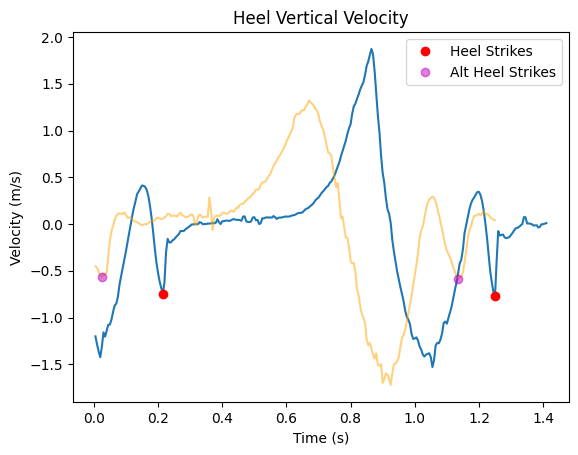

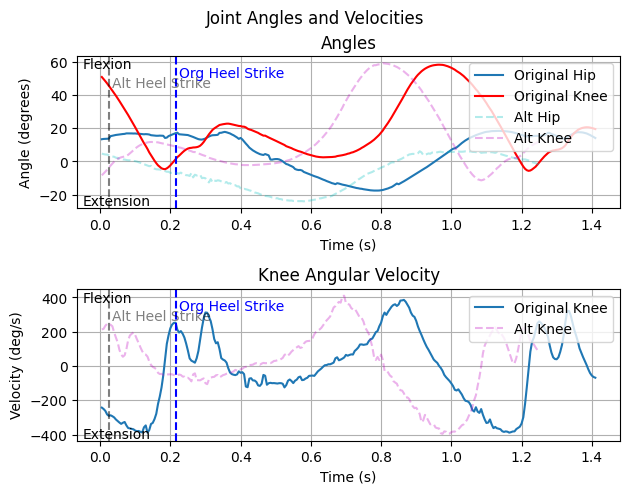

In [168]:
# Defining time vector
original_time = data_df['Time']
alt_time = alt_data_df['Time']

# Locating heel strikes
heel_strikes = locate_heel_strikes(data_df)
alt_heel_strikes = locate_heel_strikes(alt_data_df)

# Plotting heel vertical velo
plt.plot(original_time, data_df['heel_velo'])
plt.plot(alt_time, alt_data_df['heel_velo'], color='orange', alpha=0.5)
# plt.plot(time, data_df['heel_Z'])
plt.plot([original_time[i] for i in heel_strikes], 
         [data_df['heel_velo'][i] for i in heel_strikes],
         "ro", label='Heel Strikes')
plt.plot([alt_time[i] for i in alt_heel_strikes],
            [alt_data_df['heel_velo'][i] for i in alt_heel_strikes],
            "mo", label='Alt Heel Strikes', alpha=0.5)
plt.title('Heel Vertical Velocity')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.title('Heel Vertical Velocity')
print(f" Heel Strikes Occur at Times: {[float(data_df.loc[i, 'Time']) for i in heel_strikes]} seconds")

# Plotting joint angles
fig, (ax1, ax2) = plt.subplots(2, 1)
# Angles subplot
# Original data
ax1.plot(original_time, data_df['hip_angle'], label='Original Hip')
ax1.plot(original_time, data_df['knee_angle'], color='r', label='Original Knee')
ax1.axvline(original_time[heel_strikes[0]], color='b', linestyle='--')
ax1.text(original_time[heel_strikes[0]] + 0.01,  .98*max(data_df['knee_angle']), 
         'Org Heel Strike', color='b', verticalalignment='top')
ax1.text(-0.05, 0.92*max(alt_data_df['knee_angle']), "Flexion", horizontalalignment='left', verticalalignment='bottom')
ax1.text(-0.05, 0.83*min(alt_data_df['hip_angle']), "Extension", horizontalalignment='left', verticalalignment='top')


# Alt data
ax1.plot(alt_time, alt_data_df['hip_angle'], color='c', linestyle = '--', label='Alt Hip', alpha=0.3)
ax1.plot(alt_time, alt_data_df['knee_angle'], color='m', linestyle = '--', label='Alt Knee', alpha=0.3)
ax1.axvline(alt_time[alt_heel_strikes[0]], color='black', linestyle='--', alpha=0.5)
ax1.text(alt_time[alt_heel_strikes[0]] + 0.01,  .88*max(data_df['knee_angle']), 
         'Alt Heel Strike', color='black', verticalalignment='top', alpha=0.5)
ax1.set_ylabel('Angle (degrees)')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='upper right')
ax1.set_title('Angles')
ax1.grid()

# Velocities subplot
# Original data
ax2.plot(original_time, data_df['knee_velocity'], label='Original Knee')
ax2.axvline(original_time[heel_strikes[0]], color='b', linestyle='--')
ax2.text(original_time[heel_strikes[0]] + 0.01, max(data_df['knee_velocity']), 
         'Org Heel Strike', color='b', verticalalignment='top')
ax2.text(-0.05, 0.92*max(data_df['knee_velocity']), "Flexion", horizontalalignment='left', verticalalignment='bottom')
ax2.text(-0.05, 0.92*min(data_df['knee_velocity']), "Extension", horizontalalignment='left', verticalalignment='top')

# Alt data
ax2.plot(alt_time, alt_data_df['knee_velocity'], color='m', linestyle = '--', label='Alt Knee', alpha=0.3)
ax2.axvline(alt_time[alt_heel_strikes[0]], color='black', linestyle='--', alpha=0.5)
ax2.text(alt_time[alt_heel_strikes[0]] + 0.01, .86*max(data_df['knee_velocity']), 
         'Alt Heel Strike', color='black', verticalalignment='top', alpha=0.5)
ax2.set_title('Knee Angular Velocity')
ax2.set_ylabel('Velocity (deg/s)')
ax2.set_xlabel('Time (s)')
ax2.legend(loc='upper right')
ax2.grid()
plt.tight_layout()
plt.suptitle('Joint Angles and Velocities', y=1.02)
plt.savefig('Joint_Angles_and_Velocities.png', bbox_inches='tight')
plt.show()